In [1]:
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import hyperopt

from hyperopt import fmin, tpe, hp
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import datasets,layers, models
from tensorflow.keras.layers import Dense, Conv2D,Flatten, Dropout, BatchNormalization, MaxPooling2D, RandomFlip, RandomRotation, Input
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers, losses


In [2]:
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

#Нормализация входных данных
x_train = x_train / 255
x_test = x_test / 255

#Преобразование выодных значений в векторы по категориям
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

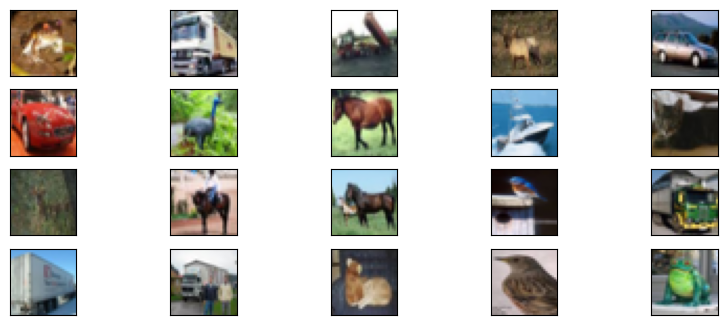

In [3]:
# Отображение первых 10 изображений из обучающей выборки
plt.figure(figsize = (10,5))
for i in range(20):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[i],cmap = plt.cm.binary)

plt.show()

In [4]:
# Формирование модели нейронной сети и вывод ее структуры

model = keras.Sequential([
    Input(shape=(32,32,3)),
    Conv2D(32,3,activation ='relu'),
    MaxPooling2D(2,padding='same'),
    Conv2D(64,3,activation='relu'),
    MaxPooling2D(2,padding = 'same'),
    Flatten(),
    Dense(256,activation='relu'),
    Dropout(0.5),
    Dense(10,activation='softmax')
    
])


In [5]:
# Компиляция нейронной сети с оптимизацией по Adam и критереем категориальной кросс-энтропия
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [6]:
# Запуск процесса обучения : 80% - обучающая выборка, 20% - выборка валидации

his = model.fit(x_train, y_train, batch_size = 32, epochs = 10, validation_split = 0.2)

Epoch 1/10
1250/1250 [==============================] - 88s 68ms/step - loss: 1.5628 - accuracy: 0.4320 - val_loss: 1.2318 - val_accuracy: 0.5689
Epoch 2/10
1250/1250 [==============================] - 85s 68ms/step - loss: 1.2220 - accuracy: 0.5672 - val_loss: 1.0839 - val_accuracy: 0.6224
Epoch 3/10
1250/1250 [==============================] - 82s 66ms/step - loss: 1.0898 - accuracy: 0.6159 - val_loss: 1.0350 - val_accuracy: 0.6358
Epoch 4/10
1250/1250 [==============================] - 80s 64ms/step - loss: 0.9938 - accuracy: 0.6493 - val_loss: 0.9489 - val_accuracy: 0.6650
Epoch 5/10
1250/1250 [==============================] - 81s 64ms/step - loss: 0.9163 - accuracy: 0.6776 - val_loss: 0.8799 - val_accuracy: 0.6919
Epoch 6/10
1250/1250 [==============================] - 84s 67ms/step - loss: 0.8587 - accuracy: 0.6980 - val_loss: 0.8712 - val_accuracy: 0.6996
Epoch 7/10
1250/1250 [==============================] - 81s 64ms/step - loss: 0.7966 - accuracy: 0.7173 - val_loss: 0.8593 -

In [7]:
print( model.evaluate(x_test, y_test))

313/313 [==============================] - 5s 17ms/step - loss: 0.9006 - accuracy: 0.6958
[0.9006292819976807, 0.6958000063896179]


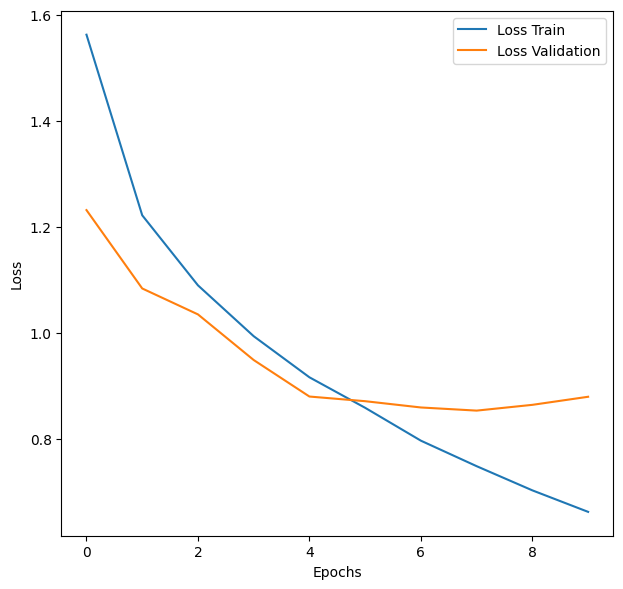

In [8]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(his.history['loss'], label='Loss Train')
plt.plot(his.history['val_loss'], label='Loss Validation')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

________________

**Использование hyperopt для подбора гиперпараметров**

In [9]:
def objective(params):
    model = Sequential([
        Input(shape=(32,32,3)),
        Conv2D(32,3,activation ='relu'),
        MaxPooling2D(2,padding='same'),
        Conv2D(64,3,activation='relu'),
        MaxPooling2D(2,padding = 'same'),
        Flatten(),
        Dense(params['units'],activation='relu'),
        Dropout(0.5),
        Dense(10,activation='softmax')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=params['learning_rate']),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test), verbose=0)
    val_accuracy = history.history['val_accuracy'][-1]
    
    return -val_accuracy  # Минимизация, так как Hyperopt ищет минимум функции

In [10]:
# Определение пространства поиска
space = {
    'units': hp.choice('units', [32, 64, 128, 256]),  # Количество нейронов в слое
    'learning_rate': hp.loguniform('learning_rate', -5, -1)  # Логарифмический выбор скорости обучения
}

In [11]:
# Запуск поиска

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10)  # Количество экспериментов

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 10/10 [1:05:02<00:00, 390.26s/trial, best loss: -0.3772999942302704]


**Использование Gread Search**

In [12]:
import numpy as np
import tensorflow as tf
import tensorflow as tf
import tensorflow.keras.layers as layers
import tensorflow.keras as keras
from tensorflow.keras import datasets,layers, models
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

In [13]:

def build_model(n_conv=2, n_kernels=64, n_hidden=2, n_neurons=64):
    model = keras.models.Sequential()

    # Input layer
    model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(layers.MaxPooling2D((2, 2)))

    # Conv layers
    for layer in range(n_conv-1):
        model.add(layers.Conv2D(n_kernels, (3, 3), activation='relu'))
        model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())

    # Hidden layers
    for layer in range(n_hidden):
        model.add(layers.Dense(n_neurons, activation="relu"))

    # Output Layer    
    model.add(layers.Dense(10, activation ='softmax'))
    return model


(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()



#Нормализация входных данных
x_train = x_train / 255
x_test = x_test / 255

#Преобразование выодных значений в векторы по категориям
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

keras_clf = KerasClassifier(
                    build_model,
                    optimizer='adam', 
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
                    


keras_clf.fit(x_train, y_train)
y_proba = keras_clf.predict_proba(x_train)

param_distribs = { "n_conv": [2, 3],
                   "n_kernels": [64, 128,256],
                    "n_hidden": [2,3],
                    "n_neurons": [64,128,256]}


search_cv = GridSearchCV(keras_clf, param_distribs, cv=3,verbose = 2)
search_cv.fit(x_train, y_train)


1563/1563 [==============================] - 17s 11ms/step
Fitting 3 folds for each of 36 candidates, totalling 108 fits


ValueError: Invalid parameter n_conv for estimator KerasClassifier.
This issue can likely be resolved by setting this parameter in the KerasClassifier constructor:
`KerasClassifier(n_conv=2)`
Check the list of available parameters with `estimator.get_params().keys()`

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

params = {
    "hidden_layer_dim": [50, 100, 200],
    "loss": ["sparse_categorical_crossentropy"],
    "optimizer": ["adam", "sgd"],
    "optimizer__learning_rate": [0.0001, 0.001, 0.1],
}
gs = RandomizedSearchCV(clf, params, refit=False, cv=3, scoring='accuracy')

gs.fit(X, y)
print(gs.best_score_, gs.best_params_)

In [ ]:
input= keras.Input(shape=(32,32,3))
x=Conv2D(32,3,activation ='relu')(input)
x=MaxPooling2D(2,padding='same')(x)
x=Conv2D(64,3,activation='relu')(x)
x=MaxPooling2D(2,padding = 'same')(x)
x=Flatten()(x)
x=Dense(256,activation='relu')(x)
x=Dropout(0.5)(x)
output = Dense(10,activation='softmax')(x)

In [ ]:
model = keras.Model(inputs=input, outputs=output)
model.summary()

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
his = model.fit(x_train, y_train, batch_size=64, epochs=5, validation_split=0.2)

Epoch 1/5
625/625 [==============================] - 32s 51ms/step - loss: 0.8169 - accuracy: 0.7167 - val_loss: 0.8502 - val_accuracy: 0.7056
Epoch 2/5
625/625 [==============================] - 31s 50ms/step - loss: 0.7405 - accuracy: 0.7392 - val_loss: 0.8226 - val_accuracy: 0.7143
Epoch 3/5
625/625 [==============================] - 31s 49ms/step - loss: 0.6706 - accuracy: 0.7654 - val_loss: 0.8377 - val_accuracy: 0.7108
Epoch 4/5
625/625 [==============================] - 32s 52ms/step - loss: 0.6087 - accuracy: 0.7866 - val_loss: 0.8005 - val_accuracy: 0.7258
Epoch 5/5
625/625 [==============================] - 33s 52ms/step - loss: 0.5505 - accuracy: 0.8067 - val_loss: 0.8334 - val_accuracy: 0.7222


In [ ]:
print( model.evaluate(x_test, y_test) )

313/313 [==============================] - 2s 6ms/step - loss: 0.8972 - accuracy: 0.6876
[0.8972135782241821, 0.6876000165939331]


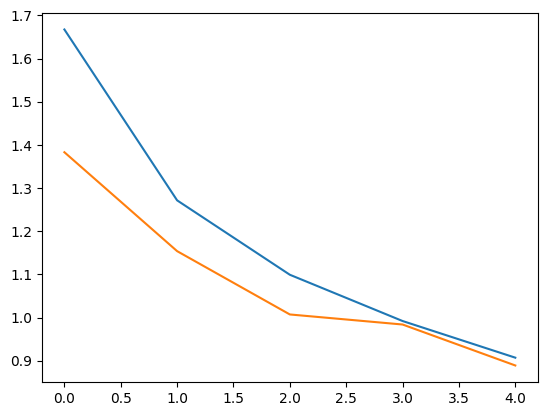

In [ ]:
plt.plot(his.history['loss'])
plt.plot(his.history['val_loss'])
plt.show()

____________

In [ ]:
input= keras.Input(shape=(32,32,3))
x=Conv2D(32,3,activation ='relu')(input)
x=MaxPooling2D(2,padding='same')(x)
x=Conv2D(64,3,activation='relu')(x)
x=MaxPooling2D(2,padding = 'same')(x)
x=Flatten()(x)
x=Dense(256,activation='relu')(x)
x=Dropout(0.5)(x)
output = Dense(10,activation='softmax')(x)